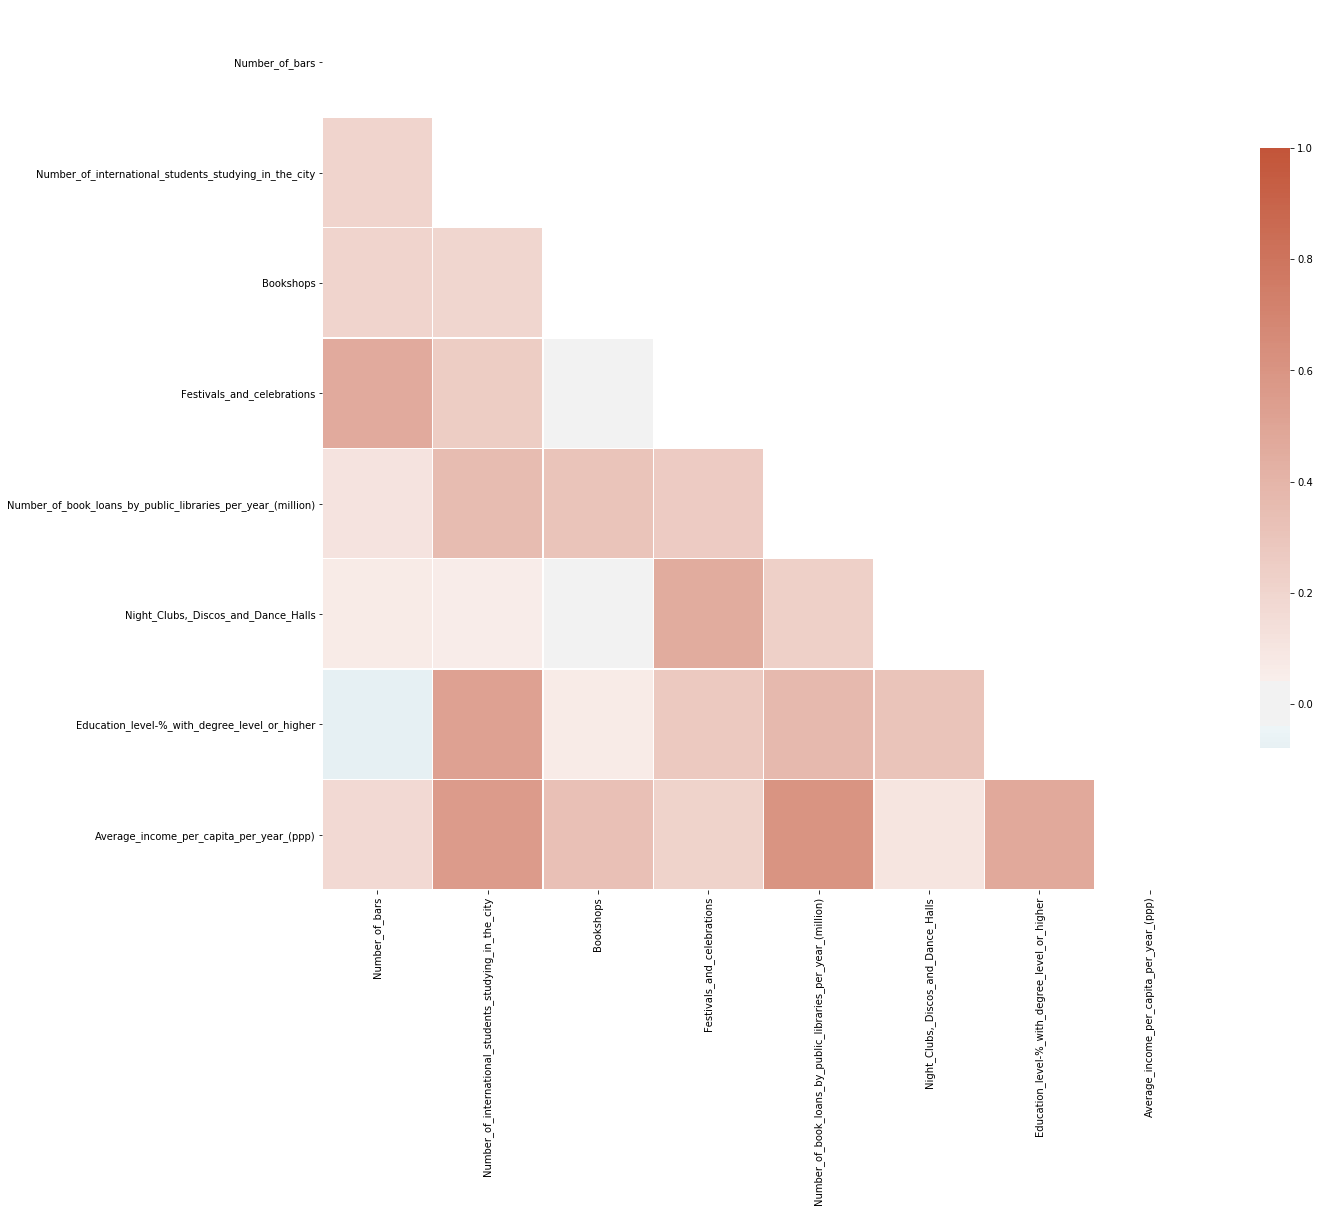

<Figure size 432x288 with 0 Axes>

In [84]:
import sys
import pandas as pd
import os
import copy
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import chardet

# correlation.sh shell script will provide python script with 2 parameters:
# 1. current directory to output results - implicitly passed by the shell script
# 2. path to config file (or its name if it is in the same directory) - explicitly passed as a shell parameter

#cur_dir = sys.argv[1]
#config_file = sys.argv[2]

cur_dir = "/Users/Utyubayev/google_drive/code/library_loans_correlation"
config_file = "config.txt"

# Reading the config file
# the config file, passed as a parameter of the shell script, must contain 5 lines:
# 1. Path to the folder with csv data files
# 2. Full name of the csv file with the target data to find correlations with (for example, number of book library loans) 
# 3. Full name of the csv file with the population numbers to normalize the data (for example, city population). If no need for such data, then leave a blank line 
# 4. Name of the columns that distinguishe rows, separated by blanks (for example, city name and date)
# 5. Name of the column that contains the data in each csv file ("figure" for example case)
with open(config_file, "r") as config:
    dataDirectory = config.readline().strip()
    targetFile = config.readline().strip()
    populationFile = config.readline().strip()
    observationColumns = config.readline().strip().split(" ")
    dataColumn = config.readline().strip()

#closing config file
config.close()

# targetColumn - name of the column (get rid of .csv), where target data will be stored
targetColumn = targetFile.split(".",1)[0]

# populationColumn - name of the column (get rid of .csv), where population data will be stored
populationColumn = populationFile.split(".",1)[0]

# get all the files from directory with the csv data files without going down the file tree
r, d, dataFiles = next(os.walk(dataDirectory))

# read data from each file and append to the main dataset
for index, file in enumerate(dataFiles):
    # temporarily store data from one csv file
    fullFilePath = dataDirectory + '/' + file
    tempDataFull = pd.read_csv(fullFilePath, encoding = "ISO-8859-1")
    
    #select only needed columns
    neededColumns = copy.deepcopy(observationColumns)
    neededColumns.append(dataColumn)
    tempData = tempDataFull[neededColumns].copy()
    
    #convert dataColumns into numbers in case they not numbers already
    if not is_numeric_dtype(tempData[dataColumn]):
        tempData[dataColumn] = tempData[dataColumn].str.replace('$','')
        tempData[dataColumn] = tempData[dataColumn].str.replace(',','')
        tempData[dataColumn] = tempData[dataColumn].str.replace('%','')
        tempData[dataColumn] = pd.to_numeric(tempData[dataColumn])
        
    # get rid of .csv in the file name to rename the data column according to the data content
    tempColumn = file.split(".",1)[0]
    tempData.rename(columns={dataColumn:tempColumn}, inplace=True)
    
    
    # if this is the first file, assign dataframe its contenr
    if index == 0:
        data = tempData.copy()
    # otherwise merge with existing dataframe
    else:
        data = pd.merge(data, tempData, how='inner', on = observationColumns)
        


#create a dictionary with population column and observation category columns for O(1) comparison time, so that we do not adjust them
excludeColumnsList = copy.deepcopy(observationColumns)
excludeColumnsList.append(populationColumn)
excludeColumns = {value: key for (key,value) in enumerate(excludeColumnsList)}

#adjust data per capita
for column in data.columns:
    #not adjusting population column
    #excluding columns that contain words per capita, %, percent, ppp
    if column not in excludeColumns and not ('ppp' in column or 'per capita' in column or '%' in column or 'percent' in column):
        data[column] = 1000 * data[column] / data[populationColumn]    

#drop population column since data is already adjusted for it
data = data.drop(columns=populationColumn)

#find correlations
result = data.corr(method='spearman')

#plot
# Generate a mask for the upper triangle
mask = np.zeros_like(result, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=[20,20])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(result, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.show()

#output results in a file

neededColumns = copy.deepcopy(observationColumns)
neededColumns.append(targetColumn)
data = data[neededColumns].sort_values(by=[targetColumn], ascending=False).reset_index(drop=True)
data["Rank"] = data[targetColumn].rank(ascending=False)

#adjust targetColumn so that it is relative to the max and rename it
data[targetColumn] = data[targetColumn] / data[targetColumn].max()
data.rename(columns={targetColumn:'relative_to_max_' + targetColumn}, inplace=True)

#move rank to the beginning
columns = data.columns
columns = columns[-1:].append(columns[:-1])
data = data[columns]

data.to_csv(cur_dir + '/adjusted_'+ targetColumn +'.csv')
#plt.savefig('correlation.png')